# Multi-Factor Models

The first part of this notebook summarizes a simple economic model that leads to a multi-factor representation of the expected returns. The second part tests a multi-factor model by OLS.

## Load Packages and Extra Functions

In [1]:
using Printf, DelimitedFiles, Statistics, LinearAlgebra

include("jlFiles/printmat.jl")
include("jlFiles/OlsGMFn.jl");             #funtcion for doing OLS

In [2]:
using Plots, LaTeXStrings

gr(size=(480,320))
default(fmt = :png)

# Portfolio Choice with Background Risk

The investor maximizes
$\text{E}R_{p}-\frac{k}{2}\text{Var}(R_{p})$, where 

$R_{p}=v^{\prime}R+\phi R_{c}+(1-\mathbf{1}^{\prime}v-\phi)R_{f}$.

In this definition of the portfolio return, $\phi$ is the fraction of total wealth that is bound to non-traded "assets": this is the background risk.

Notice that $\text{E}R_{p} = u'[\mu^e;\mu_c^e] + R_f$, where $u = [v;\phi]$ and where $\mu^e$ is the vector of excess returns on the risky assets and $\mu_c^e$ is the excess return on the background risk. 

Also, $\text{Var}(R_{p}) = u'\Omega u,$ where 

$
\Omega=\begin{bmatrix}
\Sigma & S_{c}\\
S_{c}^{\prime} & \sigma_{cc}
\end{bmatrix},
$

and where $S_{c}$ is a vector of covariances of the risky assets with the background risk,
and $\sigma_{cc}$ is the variance of the background risk.

The financial subportfolio ($v$ in risky assets and $1-\mathbf{1}^{\prime}v-\phi$ in the riskfree asset). The relative fractions inside this subportfolio are $w=v/(1-\phi)$ and $1-\mathbf{1}^{\prime}w$, respectively.

The next cell defined functions for expected utility and the optimal portfolio choice.

### A Remark on the Code

The code uses the subscript $h$ (as in $S_h$ etc) instead of $c$. The reason is that the Julia unicode subscript symbols do not include a subscripted `c`.

In [3]:
"""
    EU

Expected utility for the case with background risk. 

The notation follows the text above, except that the subscript h (as in Sₕ) for the non-traded asset, since c is not defined as a subscript in Julia.
"""
function EU(v,ϕ,k,μᵉ,Σ,Sₕ,σₕₕ,μᵉₕ,Rf)
    u     = [v;ϕ]
    μᵉAll = [μᵉ;μᵉₕ]
    ERp   = u'μᵉAll + Rf
    Ω     = [Σ   Sₕ;
             Sₕ' σₕₕ]
    VarRp = u'Ω*u
    EUtil = ERp - k/2*VarRp
    return EUtil
end

"""
    PortFOpt

Solve for the optimal weight on risky asset (v), ϕ in non-traded asset (background risk), 1-v-ϕ in Rf.

The notation follows the text above.
"""
function PortFOpt(ϕ,k,μᵉ,Σ,Sₕ)
    vopt  = inv(Σ)*(μᵉ/k-ϕ*Sₕ)
    wopt  = vopt/(1-ϕ)          #weight on risky in financial subportfolio
    return vopt, wopt
end

PortFOpt

## One Risky Asset

We first consider the case when there is only one risky asset ($v$ is a scalar). We will illustrate several cases (A,B,C) which differ with respect to the values of the fraction of non-traded asset (denoted $\phi$) and its covariance with the risk assets (denoted $S_c$ or $S_h$).

In [4]:
Σ    = 0.08^2                 #covariance (matrix) of risky assets, here only one
Sₕ_A = 0                      #covariance(s) of risky with background, case A  
Sₕ_C = 0.0025                 #case C
(μᵉ,k,σₕₕ,μᵉₕ,Rf) = (0.065,25,0.01,0.02,0.03)

v_range = range(-0.5,1,length=51)  #weight on risky investable asset
L       = length(v_range)

                                     #expected utility at different v values
(EU_case_A,EU_case_B,EU_case_C) = (fill(NaN,L),fill(NaN,L),fill(NaN,L))
for i = 1:L
    EU_case_A[i] = EU(v_range[i],0,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)     #ϕ=0
    EU_case_B[i] = EU(v_range[i],0.5,k,μᵉ,Σ,Sₕ_A,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ=0
    EU_case_C[i] = EU(v_range[i],0.5,k,μᵉ,Σ,Sₕ_C,σₕₕ,μᵉₕ,Rf)   #ϕ>0, Sₕ>0
end

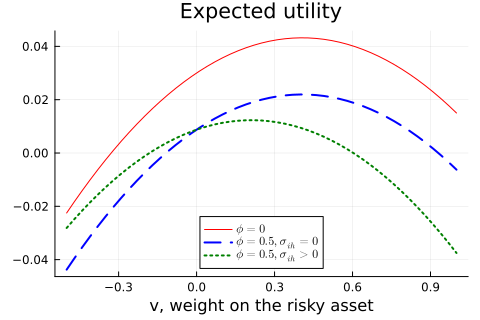

In [5]:
p1 = plot( v_range,[EU_case_A EU_case_B EU_case_C],
           linecolor = [:red :blue :green],
           linestyle = [:solid :dash :dot],
           linewidth = [1 2 2],
           label = [L"\phi=0" L"\phi=0.5, \sigma_{ih}=0 " L"\phi=0.5, \sigma_{ih}>0"],
           legend = :bottom,
           title = "Expected utility",
           xlabel = "v, weight on the risky asset" )
display(p1)

In [6]:
(v_A,w_A) = PortFOpt(0,k,μᵉ,Σ,Sₕ_A)               #optimal portfolio choice
(v_B,w_B) = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_A)
(v_C,w_C) = PortFOpt(0.5,k,μᵉ,Σ,Sₕ_C)

printblue("\nOptimal weight on (a single) risky asset in three cases (ϕ >= 0):\n")
xx = [v_A w_A;v_B w_B;v_C w_C]
colNames = ["in total portf","in financial portf"]
rowNames = ["ϕ=0","ϕ=0.5, σᵢₕ=0","ϕ=0.5, σᵢₕ>0"]
printmat(xx;colNames,rowNames,width=20)

printred("\nCompare with the plot")


Optimal weight on (a single) risky asset in three cases (ϕ >= 0):

                  in total portf  in financial portf
ϕ=0                        0.406               0.406
ϕ=0.5, σᵢₕ=0               0.406               0.812
ϕ=0.5, σᵢₕ>0               0.211               0.422


Compare with the plot


## Several Risky Assets

We now consider several risky assets.

In [7]:
μ = [11.5, 9.5, 6]/100          #expected returns
Σ = [166  34  58;               #covariance matrix
      34  64   4;
      58   4 100]/100^2
Rf = 0.03

ϕ   = 0.3                            #fraction of non-traded asset
σₕₕ = 0.25^2
Sₕ  = [0.5,0.9,-0.1].*sqrt(σₕₕ).*sqrt.(diag(Σ))
μₕ  = 0.1 
k   = 8

(v,w) = PortFOpt(ϕ,k,μ.-Rf,Σ,Sₕ)

printblue("optimal weights (inside the financial subportfolio):\n")
printmat([w;1-sum(w)],rowNames=["A","B","C","Rf"])

optimal weights (inside the financial subportfolio):

A      0.235
B      0.453
C      0.488
Rf    -0.176



# Asset Pricing Implications of a Multifactor Model

If several factors affect the portfolio choice, then they will (in equilibrium) also affect prices and returns.

Recall that a vector of regression slopes ($y$ regressed on the vector $x$) can be calculated as

$\beta = \Sigma_{xx}^{-1} S_{xy}$,

where $\Sigma_{xx}$ is the variance-covariance matrix of $x$ and $S_{xy}$ is a vector of covariance of each $x$ with $y$.

The example below assumes there are two factors.

In [8]:
μᵉF = [0.08,0.06]            #avg. excess returns of factors

Ψ = [1 0.5;                   #covariance matrix of the factors
     0.5 2]
Sₕ = [0.5,0.7]               #Cov(Ri,factor1) and Cov(Ri,factor2)

βmult = inv(Ψ)*Sₕ             #coeffs in ERᵉ = βmult'Factors
printlnPs("The multiple regression coefficients: ")
printmat(βmult)

μᵉ = βmult'μᵉF
printlnPs("μᵉ according to 2-factor model:")
printmat(μᵉ)

The multiple regression coefficients: 
     0.371
     0.257

μᵉ according to 2-factor model:
     0.045



# Empirical Test of a 3-Factor Model: Loading Data

## Load Data

In [9]:
x    = readdlm("Data/FFmFactorsPs.csv",',',skipstart=1)
Rme  = x[:,2]                #market excess return
RSMB = x[:,3]                #small minus big firms
RHML = x[:,4]                #high minus low book-to-market ratio
Rf   = x[:,5]                #interest rate


x  = readdlm("Data/FF25Ps.csv",',') #no header line: x is matrix
R  = x[:,2:end]                     #returns for 25 FF portfolios
Re = R .- Rf                        #excess returns for the 25 FF portfolios
Re = Re[:,[1,7,13,19,25]]           #use just 5 assets to make the printing easier

(T,n) = size(Re)                    #no. obs and  no. test assets

(388, 5)

## OLS Estimation and Testing α = 0

Recall: estimate $(\alpha_{i},b_{i})$ in the factor model

$R_{it}^{e}  =\alpha_{i}+b_{i}'f_{t} + \varepsilon_{it}$,

where $f_t$ is a vector of excess returns of the factors.

Test if $\alpha_{i}=0$

In [10]:
x = [ones(T) Rme RSMB RHML]         #regressors

(α,tstat) = (fill(NaN,n),fill(NaN,n))
for i = 1:n                              #loop over the different test assets
    #local b_i,Covb                      #local/global is needed in script
    (b_i,_,_,Covb,_) = OlsGMFn(Re[:,i],x)
    α[i]      = b_i[1]
    tstat[i] = (α[i]-0)/sqrt(Covb[1,1])  #t-stat for α[i]=0?
end

printblue("Regression of Re on constant and 3 factors:\n")
colNames = [string("asset ",i) for i=1:n]
printmat([α';tstat'];colNames,rowNames=["α","t-stat"])

Regression of Re on constant and 3 factors:

         asset 1   asset 2   asset 3   asset 4   asset 5
α         -0.513    -0.006     0.030    -0.020    -0.015
t-stat    -2.306    -0.066     0.328    -0.206    -0.133

